In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/FYP/models"
history_folder = "/home/dhawi/FYP/History"

In [4]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

In [5]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [6]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 1/1 [00:00<00:00, 22.93it/s]


In [7]:
fixed_noise = tf.random.normal((60, 1024))

I0000 00:00:1728571449.147882  585724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728571449.230283  585724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728571449.230355  585724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728571449.233894  585724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728571449.233969  585724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [8]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
# show_images(X_train)

In [9]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_discriminator():
    Discriminator = Sequential([
        # First convolutional layer
        layers.Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', input_shape=(128, 128, 3)),
        layers.LeakyReLU(alpha=0.2),  # Leaky ReLU activation

        # Second convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),  # Batch normalization for stability

        # Third convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # Flatten and final output layer
        layers.Flatten(),
        layers.Dense(1)  # Output single value (validity score)
    ])
    return Discriminator

In [11]:
Discriminator = build_discriminator()
Discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,153 (1.50 MB)

 Trainable params: 392,769 (1.50 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
def build_generator():
    Generator = Sequential([
        # First dense layer
        layers.Dense(8 * 8 * 128, input_shape=(1024,)),
        layers.LeakyReLU(alpha=0.2),

        # Reshape the dense output into (8, 8, 128)
        layers.Reshape((8, 8, 128)),

        # First Conv2DTranspose layer: Upsamples to (16, 16, 128)
        layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # Second Conv2DTranspose layer: Upsamples to (32, 32, 64)
        layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # Third Conv2DTranspose layer: Upsamples to (64, 64, 32)
        layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        # Fourth Conv2DTranspose layer: Upsamples to (128, 128, 3) with sigmoid activation for image output
        layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=2, padding='same', activation='sigmoid')
    ])
    return Generator

In [13]:
Generator = build_generator()
Generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,638,403 (32.95 MB)

 Trainable params: 8,637,955 (32.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
class EDWGAN(Model):
    def __init__(self, generator, discriminator, encoder, decoder, latent_dim = 1024, lambda_gp=10):
        super(EDWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.lambda_gp = lambda_gp
        self.history = {"Generator Loss": [], "Discriminator Loss": []}

    def compile(self, gen_optimizer, disc_optimizer, criterion=None):
        super(EDWGAN, self).compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def gradient_penalty(self, real_images, fake_images):
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = real_images * alpha + fake_images * (1 - alpha)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            pred = self.discriminator(interpolated_images, training=True)
        
        grads = gp_tape.gradient(pred, interpolated_images)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def discriminator_loss(self, real_output, fake_output, gp):
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        total_loss = real_loss + fake_loss + self.lambda_gp * gp
        return total_loss

    def generator_loss(self, fake_output):
        return -tf.reduce_mean(fake_output)
    
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Sample random noise
        noise = tf.random.normal((batch_size, self.latent_dim))
        noise = self.decoder(noise)
        noise = self.encoder(noise)[2]
        
        # Train Discriminator
        for _ in range(5):  # EDWGAN usually trains the discriminator more than the generator
            with tf.GradientTape() as disc_tape:
                fake_images = self.generator(noise, training=True)
                
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(fake_images, training=True)

                # Gradient Penalty
                gp = self.gradient_penalty(real_images, fake_images)
                
                # Calculate the loss for the discriminator
                disc_loss = self.discriminator_loss(real_output, fake_output, gp)
            
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.generator_loss(fake_output)

        gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        # Return loss metrics for Keras's `fit` to log
        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}




In [15]:
def build_model(model_name):
    # clear the session for a clean run
    keras.backend.clear_session()
    vae_encoder = model_folder + "/" + model_name + "_encoder.h5"
    vae_decoder = model_folder + "/" + model_name + "_decoder.h5"
    encoder = keras.src.saving.load_model(vae_encoder, custom_objects={'Sampling': Sampling}, compile=False)
    decoder = keras.src.saving.load_model(vae_decoder, compile=False)
    Generator = build_generator()
    Discriminator = build_discriminator()
    wgan_model = EDWGAN(Generator, Discriminator, encoder, decoder)
    wgan_model.compile(
        gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
        disc_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
        )
    
    return wgan_model

In [16]:
def save_model(model, model_name):
    generator_path = model_folder + "/" + model_name + "_generator.h5"
    discriminator_path = model_folder + "/" + model_name + "_discriminator.h5"
    model_path = model_folder + "/" + model_name + "_model.h5"
    model.generator.save(generator_path)
    model.discriminator.save(discriminator_path)
    model.save(model_path)

In [17]:
import matplotlib.pyplot as plt
import json

def show_history(history, model_name):
    plt.plot(history.history['Generator Loss'])
    plt.plot(history.history['Discriminator Loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [18]:
caries_edwgan = build_model("caries")
caries_edwgan_history = caries_edwgan.fit(caries, epochs = 1000, batch_size = 50)
save_model(caries_edwgan, "caries_edwgan")

Epoch 1/1000


I0000 00:00:1728571465.754817  585787 service.cc:146] XLA service 0x7f761801f950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728571465.754863  585787 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1728571484.507352  585787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - Discriminator Loss: 26.3433 - Generator Loss: 2.8640
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - Discriminator Loss: 47.7919 - Generator Loss: 3.6905
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - Discriminator Loss: -9.7666 - Generator Loss: 7.5860
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - Discriminator Loss: 23.4638 - Generator Loss: 10.5978
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - Discriminator Loss: -19.7283 - Generator Loss: 15.5279
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - Discriminator Loss: -30.4424 - Generator Loss: 20.4167
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - Discriminator Loss: -35.8121 - Generator Loss: 24.5359
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - Discriminator Loss: -42.2784 - Generator Loss: 29.2782
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - Discriminator Loss: -52.4084 - Generator Loss: 35.0326
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/s

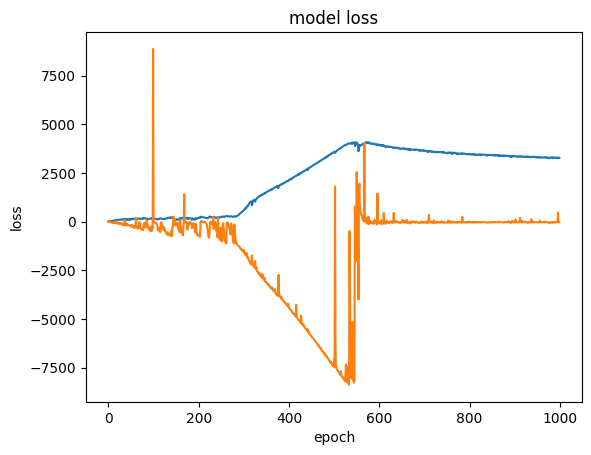

In [19]:
show_history(caries_edwgan_history, "caries_edwgan")

In [20]:
gingivitis_edwgan = build_model("gingivitis")
gingivitis_edwgan_history = gingivitis_edwgan.fit(gingivitis, epochs = 1000, batch_size = 50)
save_model(gingivitis_edwgan, "gingivitis_edwgan")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - Discriminator Loss: 73.2000 - Generator Loss: 1.7030
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - Discriminator Loss: 1.7522 - Generator Loss: 3.0692
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - Discriminator Loss: -1.6139 - Generator Loss: 6.3937
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -16.0141 - Generator Loss: 12.1190
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - Discriminator Loss: -24.1237 - Generator Loss: 16.7367
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -31.9487 - Generator Loss: 23.3782
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - Discriminator Loss: -38.1979 - Generator Loss: 28.9820
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - Discriminator Loss: -46.0803 - Generator Loss: 36.0917
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Discriminator Loss: -48.2208 - Generator Loss: 41.8986
Epoch 10/1000
1/1 ━━━━━━━━━

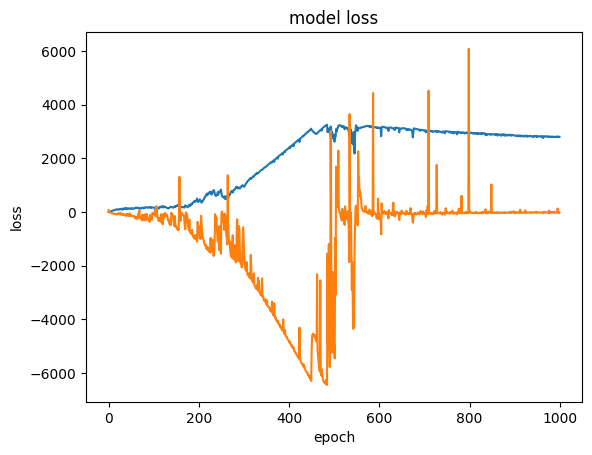

In [21]:
show_history(gingivitis_edwgan_history, "gingivitis_edwgan")

In [22]:
wsl_edwgan = build_model("wsl")
wsl_edwgan_history = wsl_edwgan.fit(wsl, epochs = 1000, batch_size = 50)
save_model(wsl_edwgan, "wsl_edwgan")

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - Discriminator Loss: 225.2354 - Generator Loss: 2.4451
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - Discriminator Loss: 5.2725 - Generator Loss: 4.3999
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - Discriminator Loss: 5.2953 - Generator Loss: 6.0622
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - Discriminator Loss: -13.8735 - Generator Loss: 10.2301
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - Discriminator Loss: -19.0659 - Generator Loss: 14.1381
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - Discriminator Loss: -28.8145 - Generator Loss: 19.6914
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - Discriminator Loss: -27.2000 - Generator Loss: 24.6049
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - Discriminator Loss: -40.3850 - Generator Loss: 30.7564
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - Discriminator Loss: -36.8497 - Generator Loss: 35.7761
Epoch 10/1000
1/1 ━━━━━━━━━

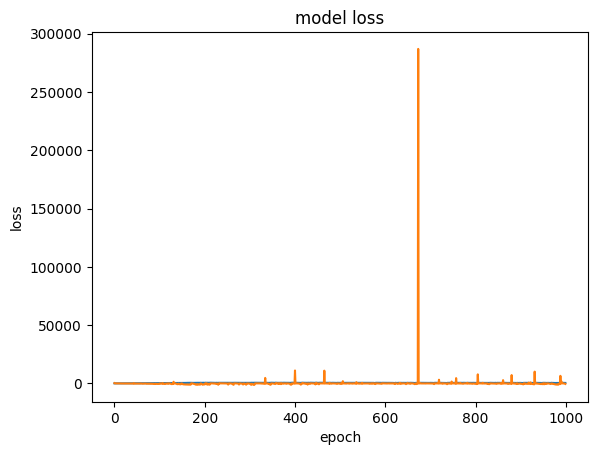

In [23]:
show_history(wsl_edwgan_history, "wsl_edwgan")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


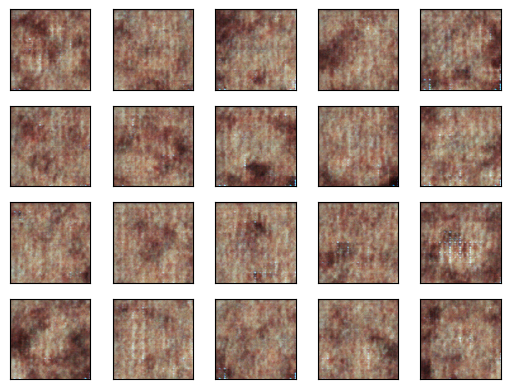

In [24]:
fixed_noise
y_pred = caries_edwgan.generator.predict(fixed_noise)
show_images(y_pred)